# Network Tolerance to Errors and Attacks
#### Author: [Erika Fille Legara](https://erikalegara.site)


[![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://github.com/eflegara/Network-Science-Lectures/blob/master/LICENSE.md)

For context, this notebook is accompanied by a lecture session under the Network Science course under [AIM's MSc in Data Science program](https://aim.edu/programs/degree-programs/master-science-data-science).

---


<table align="left" border=0>
<!-- <table class="tfo-notebook-buttons" align="left"> -->
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/eflegara/Network-Science-Lectures/blob/master/Error%20and%20Attack%20Tolerance.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/eflegara/Network-Science-Lectures/blob/master/Error%20and%20Attack%20Tolerance.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

---

Main Reference: Réka Albert, Hawoong Jeong & Albert-László Barabási (2000). "[Error and attack tolerance of complex networks](https://www.nature.com/articles/35019019)". _Nature_. **406**, pp 378–382.

In [1]:
import operator 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Let's build our hypothetical networks: a scale-free network generated using the BA model and a random network using the ER model.

In [2]:
BA = nx.barabasi_albert_graph(100, 2, seed=22)
ER = nx.erdos_renyi_graph(100, p=0.1, seed=22)

Let's have a look at the networks generated. Here, we color the nodes according to their centrality (degree centrality) in the network. Since we are considering degree centrality, we are imposing that the higher the connections of a node is, the more important that node is in the system.

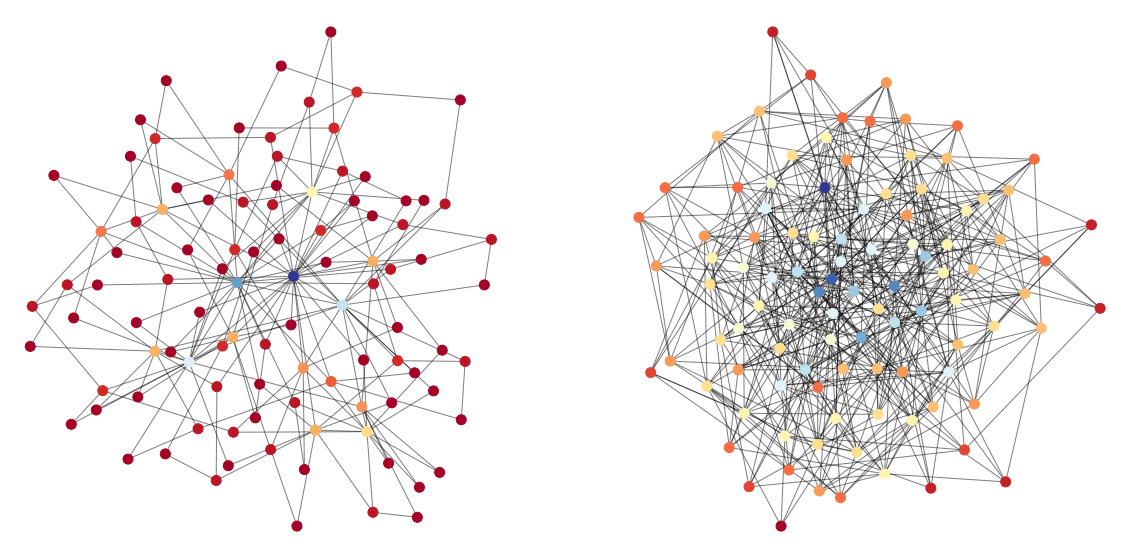

In [3]:
fig = plt.figure(figsize=(20,10))
pos = nx.fruchterman_reingold_layout(BA);
ax = fig.add_subplot(1, 2, 1);
nc = nx.draw_networkx_nodes(BA, pos, node_size=100, cmap=plt.cm.RdYlBu,
                            node_color=list(nx.degree_centrality(BA).values()));
nx.draw_networkx_edges(BA, pos, alpha=0.500);
#nx.draw_networkx_labels(BA, pos, font_color='white');
plt.axis('off');

pos = nx.fruchterman_reingold_layout(ER);
ax = fig.add_subplot(1, 2, 2);
nc = nx.draw_networkx_nodes(ER, pos, node_size=100, cmap=plt.cm.RdYlBu,
                            node_color=list(nx.degree_centrality(ER).values()));
nx.draw_networkx_edges(ER, pos, alpha=0.500);
plt.axis('off');
#nx.draw_networkx_labels(ER, pos, font_color='white');

I am also going to create one more arbitrary graph `G`.

In [4]:
G = nx.Graph()
G.add_edges_from([(0,1),(0,4),(0,5),(1,3),(1,2),
                  (1,4), (4,6), (4,7), (4,8), (4,9), 
                  (3,10), (10,11), (10,12), (12,13), 
                  (12,14), (12,15), (13,16), (16, 17), 
                  (16, 18), (8,19), (19, 20), (19,21), 
                  (19,22), (8,23), (8,24), (23,24)])

Let's explore this graph and see what happens if we randomly remove two nodes at a time.

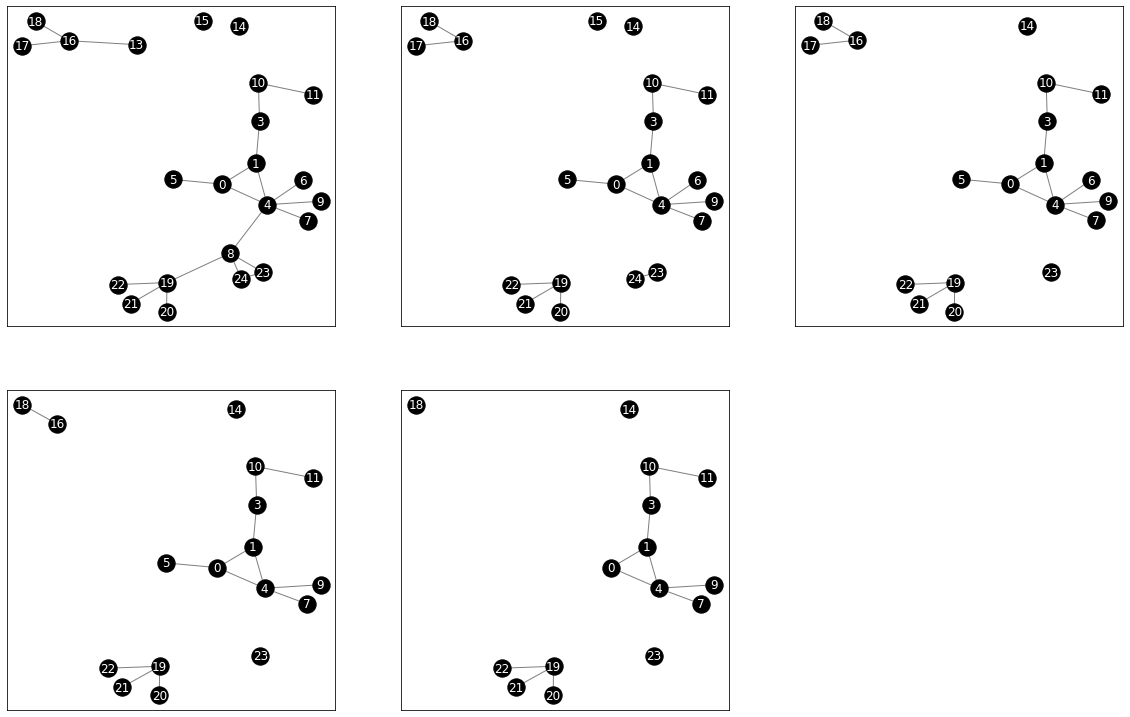

In [5]:
size = []
fig = plt.figure(figsize=(20,20));
pos = nx.fruchterman_reingold_layout(G);

for i in range(5):
    G.remove_nodes_from(np.random.choice(list(G.nodes()), 2))
    GC_nodes = max(nx.connected_components(G), key=len)
    GCC = G.subgraph(GC_nodes).copy()
    size.append(len(GCC.nodes()))

    ax = fig.add_subplot(3, 3, i+1);
    nc = nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.cm.RdYlBu,
                            node_color='black');
    nx.draw_networkx_edges(G, pos, alpha=0.500);
    nx.draw_networkx_labels(G, pos, font_color='white');
    

Let's also look at how the size of the giant component changes when systematically removing nodes.

Text(0, 0.5, 'size of giant component')

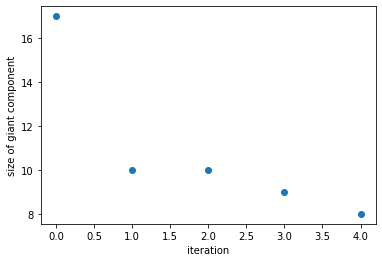

In [6]:
plt.plot(size, "o");
plt.xlabel("iteration");
plt.ylabel("size of giant component")

Now, let's go back to our ER and BA networks, both with 100 nodes, and see how the systems "breaks down" when we (1) randomly remove nodes (**error**) and (2) deliberately remove central nodes (**attack**).


In [7]:
iterations = 30
n = 100

BA = nx.barabasi_albert_graph(n, 2, seed=22)
ER = nx.erdos_renyi_graph(n, p=0.1, seed=22)

### Error

In [8]:
gc_size_ER = []
gc_size_BA = []

BA_copy = BA.copy()
ER_copy = ER.copy()

for i in range(iterations):
    BA_copy.remove_nodes_from(np.random.choice(list(BA_copy.nodes()), 2))
    GC_nodes = max(nx.connected_components(BA_copy), key=len)
    GCC = BA_copy.subgraph(GC_nodes).copy()
    BA_copy = GCC
    gc_size_BA.append(len(list(GCC.nodes()))/n)
    
    ER_copy.remove_nodes_from(np.random.choice(list(ER_copy.nodes()), 2))
    GC_nodes = max(nx.connected_components(ER_copy), key=len)
    GCC = ER_copy.subgraph(GC_nodes).copy()
    ER_copy = GCC 
    gc_size_ER.append(len(list(GCC.nodes()))/n)

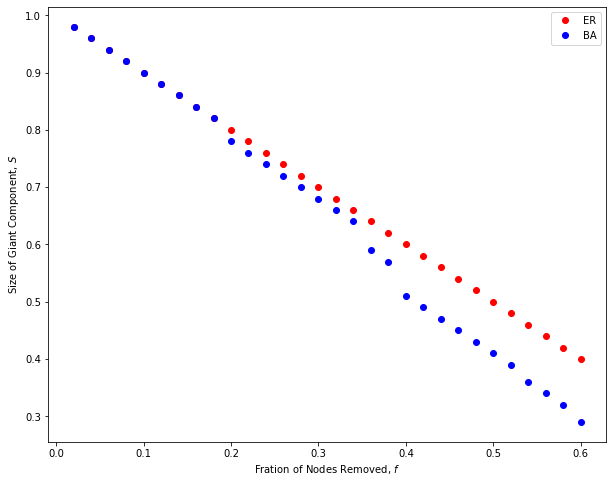

In [9]:
plt.figure(figsize=(10,8));
x = [(2+(i*2))/n for i in range(30)]
plt.plot(x, gc_size_ER, 'ro', label='ER');
plt.plot(x, gc_size_BA, 'bo', label='BA');
plt.xlabel('Fration of Nodes Removed, $f$');
plt.ylabel('Size of Giant Component, $S$');
plt.legend();

### Attack Hubs

In [10]:
gc_size_ER_attack = []
gc_size_BA_attack = []

BA_copy = BA.copy()
ER_copy = ER.copy()


for i in range(iterations):
    top = list(nx.degree_centrality(BA_copy).items())
    top.sort(key=operator.itemgetter(1), reverse=True)
    top_nodes = [nd for nd, c in top]
    BA_copy.remove_nodes_from(top_nodes[:2])
    
    try:
        GC_nodes = max(nx.connected_components(BA_copy), key=len)
        GCC = BA_copy.subgraph(GC_nodes).copy()
        BA_copy = GCC
        gc_size_BA_attack.append(len(list(GCC.nodes()))/n)
    except:
        gc_size_BA_attack.append(0)
    
    top = list(nx.degree_centrality(ER_copy).items())
    top.sort(key=operator.itemgetter(1), reverse=True)
    top_nodes = [nd for nd, c in top]
    ER_copy.remove_nodes_from(top_nodes[:2])  
  
    GC_nodes = max(nx.connected_components(ER_copy), key=len)
    GCC = ER_copy.subgraph(GC_nodes).copy()
    
    ER_copy = GCC 
    gc_size_ER_attack.append(len(list(GCC.nodes()))/n)

### Attack High Betweenness

In [11]:
gc_size_ER_attack_bw = []
gc_size_BA_attack_bw = []

BA_copy = BA.copy()
ER_copy = ER.copy()


for i in range(iterations):
    top = list(nx.betweenness_centrality(BA_copy).items())
    top.sort(key=operator.itemgetter(1), reverse=True)
    top_nodes = [nd for nd, c in top]
    BA_copy.remove_nodes_from(top_nodes[:2])
    
    try:
        GC_nodes = max(nx.connected_components(BA_copy), key=len)
        GCC = BA_copy.subgraph(GC_nodes).copy()
        BA_copy = GCC
        gc_size_BA_attack_bw.append(len(list(GCC.nodes()))/n)
    except:
        gc_size_BA_attack_bw.append(0)
    
    top = list(nx.betweenness_centrality(ER_copy).items())
    top.sort(key=operator.itemgetter(1), reverse=True)
    top_nodes = [nd for nd, c in top]
    ER_copy.remove_nodes_from(top_nodes[:2])
    
    GC_nodes = max(nx.connected_components(ER_copy), key=len)
    GCC = ER_copy.subgraph(GC_nodes).copy()
    ER_copy = GCC 
    gc_size_ER_attack_bw.append(len(list(GCC.nodes()))/n)

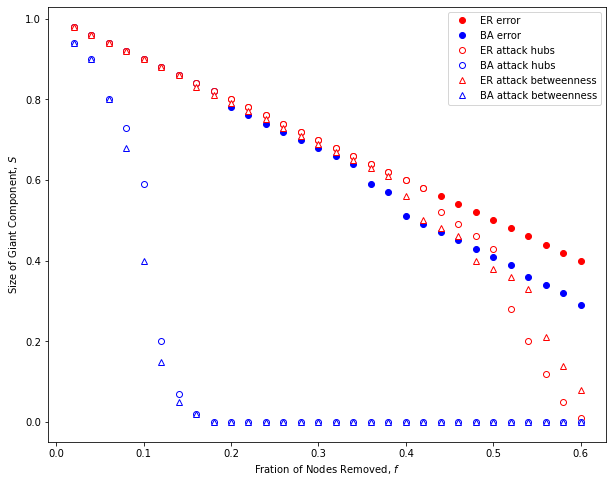

In [12]:
plt.figure(figsize=(10,8));
x = [(2+(i*2))/n for i in range(30)]
plt.plot(x, gc_size_ER, "ro", label="ER error");
plt.plot(x, gc_size_BA, "bo", label="BA error");
plt.plot(x, gc_size_ER_attack, "o", c='red', 
         markerfacecolor='white', label='ER attack hubs');
plt.plot(x, gc_size_BA_attack, "o", c='blue',  
         markerfacecolor='white', label='BA attack hubs');
plt.plot(x, gc_size_ER_attack_bw, "^", c='red', 
         markerfacecolor='white', label='ER attack betweenness');
plt.plot(x, gc_size_BA_attack_bw, "^", c='blue',  
         markerfacecolor='white', label='BA attack betweenness');
plt.xlabel('Fration of Nodes Removed, $f$');
plt.ylabel('Size of Giant Component, $S$');
plt.legend();

---

### What now?

1. Explore other ways one can attack a network.
2. What happens when you have other network structures?
3. Use real-world networks and see how vulnerable they are to errors and attacks.
4. Can we obtain any insights here on how we can potentially hamper the spread of a virus given a particular contact network?